# Algorithm developed by Dr. Steven Senger

# Comments from Dr. Ryan Udan

- the percent area occupied by vsmcs (before investment) is about 3.6%
- cells are approximately 12 um in width and 20 um in length

# Things to do

- Cache data for repeated trials with the same/similar paramters (maybe Dill?)

In [1]:
from collections import deque
from math import inf
from random import shuffle, randrange
from time import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

In [2]:
# Image preprocessing
binary_threshold = 10

# Connected components
connection_radius = 2

# Latice and region creation
lattice_radius = 50
lattice_stride = 50
min_component_size = 2

# Simulation
num_free_cells = 50
neighborhood = 1
max_iterations = 10

# Meta
verbose = True
showplots = True

image = Image.open("images/binary.jpg")

In [3]:
def binarize_and_threshold_image(image, threshold):
    """Take any image with values in [0 255] and convert all values to 0 or 1.
    
    args
        image : an image with any number of channels and any value range
        threshold : all value below or equal to the threshold are set to 0
    
    return the binarized image as a numpy matrix
    """
    
    binary_image = image.convert('L')
    
    binary_image_array = np.array(binary_image)
    
    binary_image_array[binary_image_array <= threshold] = 0
    binary_image_array[binary_image_array >  threshold] = 1
    
    return binary_image_array

start = time()
binary_image = binarize_and_threshold_image(image, binary_threshold)
if verbose:
    print(binary_image.shape, binary_image.dtype)
    print(f'Time to binarize the input image: {time() - start:0.3f}s\n')

(512, 512) uint8
Time to binarize the input image: 0.009s



In [4]:
def create_matrix_from_adjacency_list(matrix, radius, epsilon=0.00001):
    """Create an adjacency list graph from an image matrix.
    
    args
        matrix : an m-by-n matrix
        radius : minimum cell distance to consider between connected vertices
        epsilon : floating-point comparison threshold
    
    return adjacency list graph
    """
    
    adj_list = {}
    
    width, height = matrix.shape
    
    num_digits = len(str(height))

    # Consider each cell row
    for row in range(height):
        
        # Use radius to get the top (rt) and bottom (rb) bounds on the
        # neighboring rows
        rt = max(0, row - radius)
        rb = min(height, row + radius + 1)
        
        # All row index values in the range
        y = np.arange(rt, rb)

        # Consider each cell column
        for col in range(width):
            
            # Use radius to get the left (cl) and right (cr) bounds on the
            # neighboring columns
            cl = max(0, col - radius)
            cr = min(width, col + radius + 1)
            
            # All column index values in the range
            x = np.arange(cl, cr)

            # Color of the "current" cell
            cell_color = matrix[row, col]

            # All cell indices in the range
            xg, yg = np.meshgrid(x, y)
            
            # All cells within the threshold distance
            dists = np.sqrt((xg - col)**2 + (yg - row)**2)
            within_radius = dists <= (radius + epsilon)

            # All cells with the same color
            connect = np.logical_and(matrix[rt:rb, cl:cr] == cell_color, within_radius)

            # Update the adjcenecy matrix will all matching colors
            adj_list[(row, col)] = {(x + rt, y + cl) for (x,y) in np.argwhere(connect)}
        
        if verbose and row % 100 == 0:
            print(f'Completed processing row {row:>{num_digits}} of {height-1}')
    
    return adj_list

start = time()
adj_list = create_matrix_from_adjacency_list(binary_image, connection_radius)
if verbose:
    print('Number of vertices in graph:', len(adj_list))
    print(f'Time to create graph: {time() - start:0.3f}s\n')

Completed processing row   0 of 511
Completed processing row 100 of 511
Completed processing row 200 of 511
Completed processing row 300 of 511
Completed processing row 400 of 511
Completed processing row 500 of 511
Number of vertices in graph: 262144
Time to create graph: 24.589s



In [5]:
def bfs(adj_list, start_vertex):
    """Breadth-first search for adjacency list.
    
    args
        adj_list : graph in adjacency list form
        start_vertex : beginning vertex for bfs
    
    return all connected vertices
    """
    
    found = {start_vertex}
    
    visit_queue = deque([start_vertex])

    while len(visit_queue) != 0:
        v_found = visit_queue.popleft()
        for v_other in adj_list[v_found]:
            if v_other not in found:
                found.add(v_other)
                visit_queue.append(v_other)
    
    return found

def find_connected_compnents(adj_list):
    """Compute all connected components of adjacency list.
    
    args
        adj_list : graph in adjacency list form
    
    return all components
    """
    
    components = []
    
    all_found = set()
    
    for vertex in adj_list:
        if vertex not in all_found:
            component = bfs(adj_list, vertex)
            components.append(component)
            all_found |= component
    
    return components

start = time()
components = find_connected_compnents(adj_list)
num_components = len(components)
if verbose:
    print('Number of components:', num_components)
    print(f'Time to compute connected components: {time() - start:0.3f}s\n')

Number of components: 459
Time to compute connected components: 1.207s



In [6]:
def round_to_stride(value, stride):
    return int(stride * round(value/stride))

def create_lattice_of_component_counts(input_shape, radius, stride, components, min_size):
    """Create lattice where each cell indicates the number of components within radius.

    args
        input_shape : shape of the lattice
        radius : distance away from lattice cell to search for components
        stride : distance between lattice cells
        components : all components of the original graph
        min_size : ignore all components with fewer than min_size vertices
        
    return the lattice
    """
    
    max_row, max_col = input_shape

    # Size the lattice based on the input shape and the stride
    # (the plus one is to account for starting the stride at 0 and potentially
    # ending on the last column or row)
    lattice_height = max_row // stride
    lattice_width = max_col // stride
    lattice = np.zeros((lattice_height, lattice_width), dtype=np.uint)
    
    num_digits = len(str(len(components)))
    
    for (i, component) in enumerate(components):
        
        indices_to_skip = set()
        
        if len(component) >= min_size:
        
            for (vy, vx) in component:

                # Radius around current component vertex taking
                # into account the stride
                rt = round_to_stride(max(0, vy - radius), stride)
                rb = min(max_row, vy + radius + 1)

                cl = round_to_stride(max(0, vx - radius), stride)
                cr = min(max_col, vx + radius + 1)
                
                for y in range(rt, rb, stride):
                    for x in range(cl, cr, stride):
                        if (y, x) not in indices_to_skip:
                            dist = np.sqrt((vx - x)**2 + (vy - y)**2)
                            if dist < radius:
                                
                                # Convert the cell indices to lattice indices by
                                # considering the stride
                                try:
                                    lattice[y//stride, x//stride] += 1
                                except:
                                    # Ignore out of bounds as it is an artifact of starting
                                    # the stride at 0
                                    pass
                                indices_to_skip.add((y, x))

        if verbose and i % 10 == 0:
            print(f'Completed processing component {i:>{num_digits}} of {len(components)-1}')
            
    return lattice

start = time()
lattice = create_lattice_of_component_counts(binary_image.shape, 
                                                   lattice_radius, 
                                                   lattice_stride, 
                                                   components, 
                                                   min_component_size)
if verbose:
    print(f'Time to create lattice: {time() - start:0.3f}s\n')

Completed processing component   0 of 458
Completed processing component  10 of 458
Completed processing component  20 of 458
Completed processing component  30 of 458
Completed processing component  40 of 458
Completed processing component  50 of 458
Completed processing component  60 of 458
Completed processing component  70 of 458
Completed processing component  80 of 458
Completed processing component  90 of 458
Completed processing component 100 of 458
Completed processing component 110 of 458
Completed processing component 120 of 458
Completed processing component 130 of 458
Completed processing component 140 of 458
Completed processing component 150 of 458
Completed processing component 160 of 458
Completed processing component 170 of 458
Completed processing component 180 of 458
Completed processing component 190 of 458
Completed processing component 200 of 458
Completed processing component 210 of 458
Completed processing component 220 of 458
Completed processing component 230

In [7]:
def get_brightnesses_from_image(image, stride):
    """Compute scaled brightness for image.
    
    args
        image : image input
        stride : stride used for lattice (different function)
    
    return values caled in [-1 1] with the same shape as the lattice
    """
    
    mat = np.array(image)
    
    # Full height and width rounded down to max stride index
    fh, fw, _ = mat.shape
    fh = fh//stride * stride
    fw = fw//stride * stride
    
    # Scaled height and width
    sh, sw = fh // stride, fw // stride

    # Lop of edges of image if necessary and average over RGB channels
    mat = mat[:fh, :fw].mean(2)
    
    # Average each stride-by-stride box
    mat = mat.reshape((sh, stride, sw, stride)).mean(3).mean(1)
    
    # Scale to [-1 1]
    max_val = np.amax(mat)
    return mat / max_val * 2 - 1

def compute_region_scores(lattice, brightness):
    """Compute region scores based on graph components and brightness.
    
    args
        lattice : lattice computed from graph components
        brightness : scaled values from the original image
    
    return
    """
    
    max_components = np.amax(lattice)
    
    regions = lattice - max_components/2
    regions *= brightness
    return regions

start = time()
brightness = get_brightnesses_from_image(image, lattice_stride)
regions = compute_region_scores(lattice, brightness)
if verbose:
    print(f'Time to create regions: {time() - start:0.3f}s\n')

Time to create regions: 0.019s



In [8]:
def travel(ycell, xcell, regions, neighborhood, cell_grid):
    """Move a VSMCS from its current location based on its neighborhood.
    
    args
        ycell : cell's current y index
        xcell : cell's current x index
        regions : grid of attraction/repulsion
        neighborhood : area in which to search for a new position
        cell_grid : current status of all cells
    
    return a new location for the cell
    """

    score = regions[ycell, xcell] if cell_grid[ycell, xcell] == EMPTY else inf
    
    ynew, xnew = ycell, xcell
    
    height, width = cell_grid.shape

    ymin = max(0, ycell - neighborhood)
    ymax = min(height, ycell + neighborhood + 1)

    xmin = max(0, xcell - neighborhood)
    xmax = min(width, xcell + neighborhood + 1)
                    
    for y in range(ymin, ymax):
        for x in range(xmin, xmax):

            neigh_score = regions[y, x]
            
            if neigh_score < score and cell_grid[y, x] == EMPTY:
                score = neigh_score
                ynew, xnew = y, x
    
    # What should we do if the cell gets trapped?
    #assert(score != inf)
    return ynew, xnew

cell_grid = np.zeros_like(regions, dtype=np.bool)

height, width = cell_grid.shape

# Initial cell placements (allowing colocated cells)
MOVING, STATIONARY, EMPTY = True, False, False
cells = [(randrange(height), randrange(width), MOVING) for _ in range(num_free_cells)]

# Cells do not collide and can temporarily occupy the same space
for iteration in range(max_iterations):
    
    if num_free_cells == 0:
        break

    for i, (y, x, free) in enumerate(cells):
        if free == MOVING:
            ynew, xnew = travel(y, x, regions, neighborhood, cell_grid)

            # No movement
            if ynew == y and xnew == x:
                cell_grid[y, x] = True
                cells[i] = (y, x, STATIONARY)
                num_free_cells -= 1

            # Still moving
            else:
                cells[i] = (ynew, xnew, MOVING)
    
    if verbose:
        print(f'Iteration {iteration:>3}: {num_free_cells:>3} cells still moving.')

Iteration   0:  42 cells still moving.
Iteration   1:  27 cells still moving.
Iteration   2:  24 cells still moving.
Iteration   3:  17 cells still moving.
Iteration   4:  13 cells still moving.
Iteration   5:  10 cells still moving.
Iteration   6:   7 cells still moving.
Iteration   7:   6 cells still moving.
Iteration   8:   6 cells still moving.
Iteration   9:   5 cells still moving.


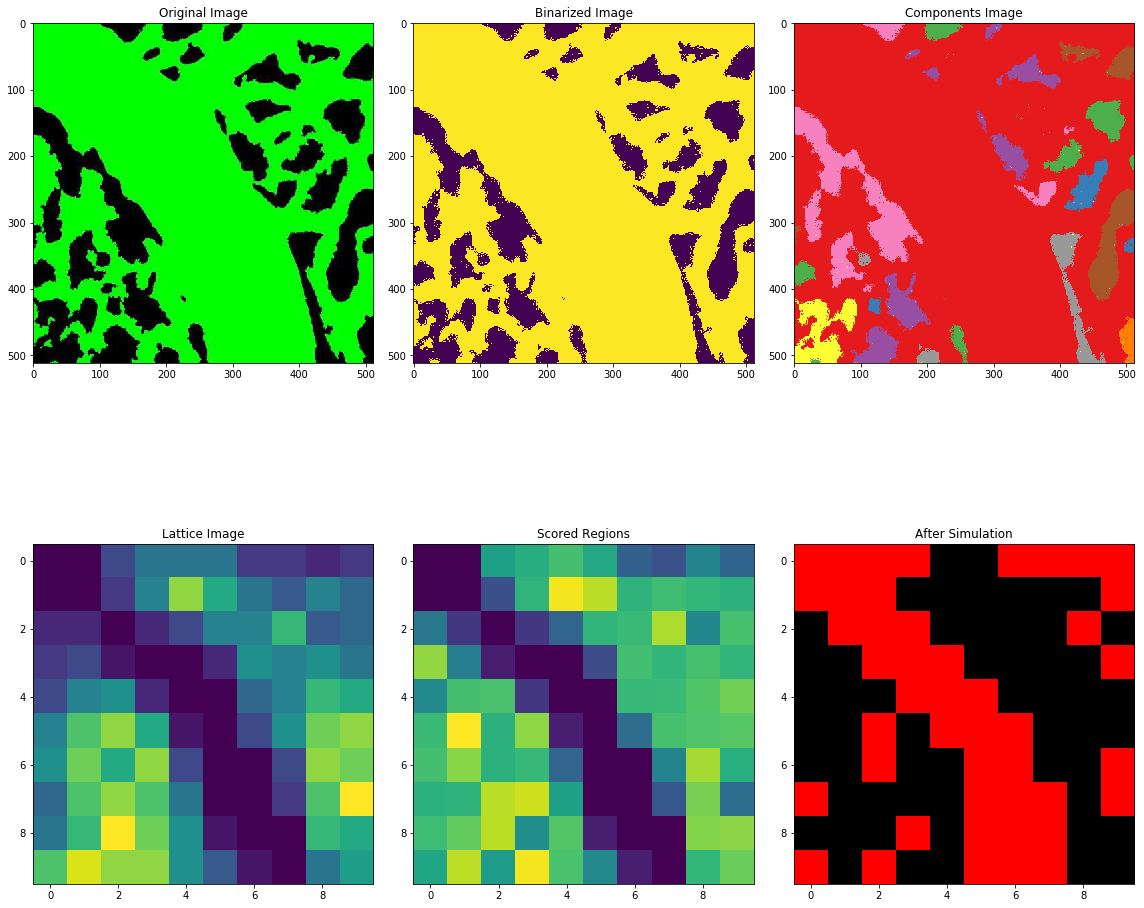

In [9]:
if showplots:

    components_image = np.zeros_like(image, dtype=np.float)
    
    component_cmap = plt.get_cmap('Set1', num_components)
    
    # Shuffle to see different colorings since some colors are repeated
    shuffle(components)

    for i, component in enumerate(components):        
        component_color = component_cmap(i/num_components)[:3]
        for (vy, vx) in component:
            components_image[vy, vx, :] = component_color

    fig, axes = plt.subplots(2, 3, figsize=(16, 16))
    axes = [ax for sublist in axes for ax in sublist]
    
    cell_image = np.zeros(list(cell_grid.shape) + [3])
    cell_image[:,:,0] = cell_grid
    
    plots = [
        (image, 'Original Image'),
        (binary_image, 'Binarized Image'),
        (components_image, 'Components Image'),
        (lattice, 'Lattice Image'),
        (regions, 'Scored Regions'),
        (cell_image, 'After Simulation')
    ]
    
    for ax, (img, ttl) in zip(axes, plots):
        ax.imshow(img);
        ax.set_title(ttl);
    plt.tight_layout()